In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utilities import * 
from model import * 
from training import * 

import torch

In [185]:
data_path = './Data/'
#data_path = '/Users/ramesh/Documents/Anoushka_Thesis/COR_Data/'
models_folder = './models/'

In [5]:
alliance_df = pd.read_csv(data_path + 'version4.1_csv/alliance_v4.1_by_directed_yearly.csv')
alliance_df.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012.0,1,1,1,0,1.0,0.0,1816,4.1
1,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012.0,1,1,1,0,1.0,0.0,1817,4.1
2,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012.0,1,1,1,0,1.0,0.0,1818,4.1
3,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012.0,1,1,1,0,1.0,0.0,1819,4.1
4,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012.0,1,1,1,0,1.0,0.0,1820,4.1


In [6]:
alliance_df = alliance_df[['ccode1','state_name1','ccode2','state_name2','year','defense','neutrality','nonaggression','entente']]
alliance_df['label'] = alliance_df['defense']
alliance_df = alliance_df[alliance_df['label'] == 1]
len(alliance_df)
alliance_df.head()

,ccode1,state_name1,ccode2,state_name2,year,defense,neutrality,nonaggression,entente,label
0,200,United Kingdom,235,Portugal,1816,1,0,1.0,0.0,1
1,200,United Kingdom,235,Portugal,1817,1,0,1.0,0.0,1
2,200,United Kingdom,235,Portugal,1818,1,0,1.0,0.0,1
3,200,United Kingdom,235,Portugal,1819,1,0,1.0,0.0,1
4,200,United Kingdom,235,Portugal,1820,1,0,1.0,0.0,1


In [7]:
alliance_df['defense'].value_counts(), alliance_df['neutrality'].value_counts(), alliance_df['nonaggression'].value_counts(), alliance_df['entente'].value_counts()

(1    113585
 Name: defense, dtype: int64,
 0    113246
 1       339
 Name: neutrality, dtype: int64,
 1.0    80175
 0.0    33389
 Name: nonaggression, dtype: int64,
 1.0    94196
 0.0    19389
 Name: entente, dtype: int64)

In [8]:
stats_df = calculate_edge_stats(alliance_df[['year','ccode1','ccode2']])
stats_df.values

array([[1817,   74,    0,    0],
       [1818,   74,    0,    0],
       [1819,   74,    0,    0],
       [1820,   74,    0,    0],
       [1821,   70,    0,    4],
       [1822,   70,    0,    0],
       [1823,   60,    0,   10],
       [1824,   60,    0,    0],
       [1825,   60,    0,    0],
       [1826,   60,    0,    0],
       [1827,   60,    0,    0],
       [1828,   60,    0,    0],
       [1829,   60,    0,    0],
       [1830,   60,    0,    0],
       [1831,   62,    2,    0],
       [1832,   65,    3,    0],
       [1833,   73,    8,    0],
       [1834,   75,    4,    2],
       [1835,   75,    0,    0],
       [1836,   75,    0,    0],
       [1837,   75,    0,    0],
       [1838,   91,   16,    0],
       [1839,   91,    0,    0],
       [1840,   95,    9,    5],
       [1841,   86,    0,    9],
       [1842,   84,    0,    2],
       [1843,  102,   18,    0],
       [1844,  102,    0,    0],
       [1845,  102,    0,    0],
       [1846,  102,    0,    0],
       [18

In [9]:
country_codes_df = pd.read_csv(data_path + "COW-country-codes.csv")
country_codes_df['StateAbb'] = country_codes_df['StateAbb'].astype(str)
country_codes_df = country_codes_df.drop_duplicates()
print(len(country_codes_df), min(country_codes_df['CCode']), max(country_codes_df['CCode']))
country_codes_df.head()

217 2 990


,StateAbb,CCode,StateNme
0,USA,2,United States of America
1,CAN,20,Canada
2,BHM,31,Bahamas
3,CUB,40,Cuba
5,HAI,41,Haiti


In [10]:
countries = sorted(list(set(list(alliance_df['ccode1'].unique()) + list(alliance_df['ccode2'].unique()))))
years = sorted(list(alliance_df['year'].unique()))
num_nodes = len(countries)
num_years = len(years)

In [11]:
#regime_raw_df = pd.read_csv("https://ourworldindata.org/grapher/political-regime.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
regime_raw_df = pd.read_csv(data_path + "political-regime.csv")
# Fetch the metadata
#regime_raw_metadata = requests.get("https://ourworldindata.org/grapher/political-regime.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

regime_raw_df.head()

,Entity,Code,Year,regime_row_owid
0,Afghanistan,AFG,1789,0
1,Afghanistan,AFG,1790,0
2,Afghanistan,AFG,1791,0
3,Afghanistan,AFG,1792,0
4,Afghanistan,AFG,1793,0


In [12]:
religion_df = pd.read_csv(data_path + 'WRP_national_manipulated_for_code.csv')
religion_df.head()

,year,state,name,dominantreligionasvalues
0,1945,2,USA,chrstprotpct
1,1950,2,USA,chrstprotpct
2,1955,2,USA,chrstprotpct
3,1960,2,USA,chrstprotpct
4,1965,2,USA,chrstprotpct


In [13]:
rel_df = religion_df[['year', 'state', 'dominantreligionasvalues']]
rel_df['dominantreligionasvalues'] = rel_df['dominantreligionasvalues'].astype('category')

religion_countries = list(rel_df['state'].unique())

missing_rel_countries = []
extra_rel_countries = []

for c in countries:
    if c not in religion_countries:
        missing_rel_countries.append(c)
        
for c in religion_countries:
    if c not in countries:
        extra_rel_countries.append(c)
        
missing_rel_df = pd.DataFrame({'year': [1960 for _ in missing_rel_countries], 
              'state': [c for c in missing_rel_countries], 
              'dominantreligionasvalues': ['unknown' for _ in missing_rel_countries]})

rel_df = rel_df[rel_df['state'].isin(countries)]
rel_df = pd.concat([rel_df, missing_rel_df])

len(missing_rel_countries), len(extra_rel_countries), len(rel_df['state'].unique())

(14, 50, 164)

In [14]:
# List of all years between 1816 and 2012
all_years = pd.DataFrame({'year': range(1816, 2013)})

def interpolate_religion_values(group):
    country_name = group['state'].iloc[0]
    country_years = pd.DataFrame({'year': all_years['year'], 'state': country_name})
    group = pd.merge(country_years, group, how='left', on=['state', 'year'])
    group['dominantreligionasvalues'] = group['dominantreligionasvalues'].ffill().bfill()
    return group

result_religion = rel_df.groupby('state').apply(interpolate_religion_values).reset_index(drop=True)
print(result_religion[['year', 'state', 'dominantreligionasvalues']])
#result[result_religion["state"] == 115].values

       year  state dominantreligionasvalues
0      1816      2             chrstprotpct
1      1817      2             chrstprotpct
2      1818      2             chrstprotpct
3      1819      2             chrstprotpct
4      1820      2             chrstprotpct
...     ...    ...                      ...
32303  2008    920              chrstangpct
32304  2009    920              chrstangpct
32305  2010    920              chrstangpct
32306  2011    920              chrstangpct
32307  2012    920              chrstangpct

[32308 rows x 3 columns]


In [15]:
regime_feature_length = len(regime_raw_df['regime_row_owid'].unique())
religion_feature_length = len(result_religion['dominantreligionasvalues'].unique())
religion_types = sorted(list(result_religion['dominantreligionasvalues'].unique()))
yearly_base_features = {t: {c: create_onehot_vector(num_nodes, countries.index(c)) for c in countries} for t in years}
yearly_regime_features = {t: {c: np.zeros(regime_feature_length) for c in countries} for t in years}
yearly_religion_features = {t: {c: np.zeros(religion_feature_length) for c in countries} for t in years}

num_nodes, num_years, len(yearly_base_features), len(yearly_regime_features), len(yearly_religion_features)

(164, 197, 197, 197, 197)

In [16]:
#process regime features
for index, row in regime_raw_df.iterrows():
    crow = country_codes_df[country_codes_df['StateNme'] == row['Entity']]
    if crow['CCode'].values.shape[0] > 0:
        ccode = crow['CCode'].values[0]
        if row['Year'] in years and ccode in countries:
            yearly_regime_features[row['Year']][ccode] = create_onehot_vector(regime_feature_length, row['regime_row_owid'])
            
#process religion features
for index, row in result_religion.iterrows():
    ccode = row['state']
    if row['year'] in years and ccode in countries:
        religion_idx = religion_types.index(row['dominantreligionasvalues'])
        yearly_religion_features[row['year']][ccode] = create_onehot_vector(religion_feature_length, religion_idx)
    
year = years[10]
x_base = np.array(list(yearly_base_features[year].values()))
x_regime = np.array(list(yearly_regime_features[year].values()))
x_religion = np.array(list(yearly_religion_features[year].values()))
x = np.hstack([x_base, x_regime, x_religion])
x_base.shape, x_regime.shape, x_religion.shape, x.shape

((164, 164), (164, 4), (164, 16), (164, 184))

In [17]:
diw_df = pd.read_csv(data_path + 'Dyadic-Interstate-War-Dataset/directed_dyadic_war.csv')
diw_df = diw_df[['year','warnum','statea','stateb']].drop_duplicates()

diw_years = {}
for index, row in diw_df.iterrows():
    year = row['year']
    if year not in diw_years:
        diw_years[year] = []
    diw_years[year].append( (row['statea'],row['stateb']) )

len(diw_years), len(diw_years[1823])

(120, 2)

In [18]:
prox_df = pd.read_csv(data_path + 'DirectContiguity320/contdird.csv')
prox_df = prox_df[['state1ab','state2ab','year','conttype']].drop_duplicates()

prox_types = sorted([-1] + list(prox_df['conttype'].unique()))
default_prox_onehot = create_onehot_vector(len(prox_types), prox_types.index(-1))

prox_years = {}
for index, row in prox_df.iterrows():
    year = row['year']
    if year not in prox_years:
        prox_years[year] = {}
    prox_onehot = create_onehot_vector(len(prox_types), prox_types.index(row['conttype']))
    prox_years[year][(row['state1ab'],row['state2ab'])] = prox_onehot
    
    
len(prox_years), len(prox_years[1823])

(201, 120)

In [19]:
%%time

cntry_code_map = {}
code_cntry_map = {}
yearly_edges = OrderedDict()
yearly_diw_edge_features = OrderedDict()
yearly_prox_edge_features = OrderedDict()
yearly_edge_features = OrderedDict()
yearly_nodes = OrderedDict()
for year in sorted(list(alliance_df['year'].unique())):
    yearly_edges[year] = []
    yearly_diw_edge_features[year] = []
    yearly_edge_features[year] = []
    yearly_prox_edge_features[year] = []
    yearly_nodes[year] = []
    
for index, row in alliance_df[['ccode1','ccode2','state_name1','state_name2','year']].iterrows():
    year = row['year']
    if row['ccode1'] not in code_cntry_map:
        code_cntry_map[row['ccode1']] = row['state_name1']
        yearly_nodes[year].append(row['ccode1'])
    if row['ccode2'] not in code_cntry_map:
        code_cntry_map[row['ccode2']] = row['state_name2']
    if row['state_name1'] not in cntry_code_map:
        cntry_code_map[row['state_name1']] = row['ccode1']
        yearly_nodes[year].append(row['ccode2'])
    if row['state_name2'] not in cntry_code_map:
        cntry_code_map[row['state_name2']] = row['ccode2']
    
    if row['ccode1'] not in yearly_nodes[year]:
        yearly_nodes[row['year']].append(row['ccode1'])
    elif row['ccode2'] not in yearly_nodes[year]:
        yearly_nodes[year].append(row['ccode2'])
    
    if (row['ccode1'],row['ccode2']) not in yearly_edges[year]:
        yearly_edges[year].append((row['ccode1'],row['ccode2']))
        
        f = 0
        if year in diw_years:
            if (row['ccode1'],row['ccode2']) in diw_years[year]:
                f = 1
        yearly_diw_edge_features[year].append(f)
        oh = default_prox_onehot
        if year in prox_years:
            if (row['ccode1'],row['ccode2']) in prox_years[year]:
                oh = prox_years[year][(row['ccode1'],row['ccode2'])]
        yearly_prox_edge_features[year].append(oh)    
        
        yearly_edge_features[year].append(np.hstack([f, oh]))
    
yearly_nodes = {k: list(set(yearly_nodes[k])) for k in yearly_nodes}

len(yearly_nodes), len(yearly_edge_features), len(yearly_diw_edge_features), len(yearly_prox_edge_features), len(yearly_edges), len(yearly_edges[1916]), len(yearly_edges[2012]), len(code_cntry_map), len(cntry_code_map)

CPU times: user 18.3 s, sys: 180 ms, total: 18.5 s
Wall time: 18.4 s


(197, 197, 197, 197, 197, 37, 2277, 164, 164)

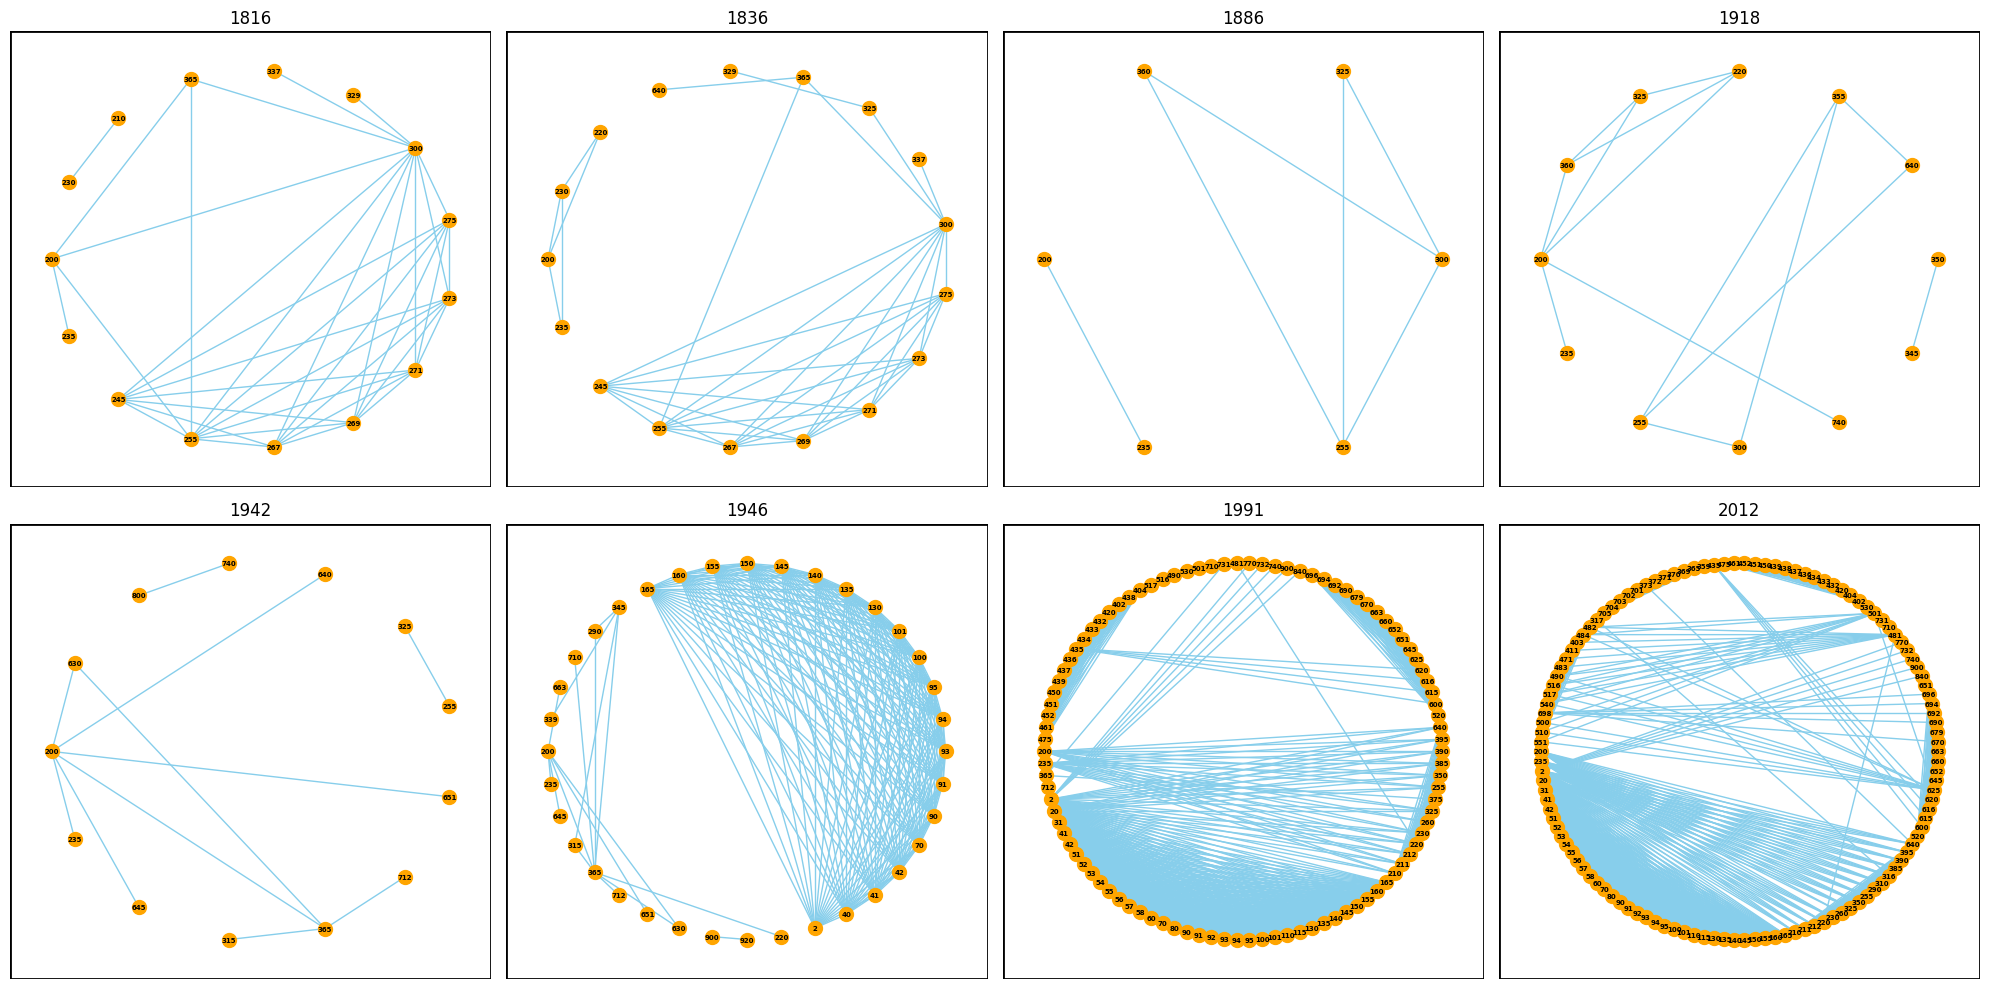

In [20]:
import matplotlib.patches as patches

viz_years = {k: yearly_edges[k] for k in [1816, 1836, 1886, 1918, 1942, 1946, 1991, 2012]}
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each graph
for i, (year, edges) in enumerate(viz_years.items()):
    G = nx.Graph()
    G.add_edges_from(edges)
    #pos = nx.spring_layout(G)
    pos = nx.shell_layout(G)

    ax = axes[i]
    nx.draw(G, pos, ax=ax, with_labels=True, node_size=100, 
            node_color="orange", edge_color='skyblue', font_size=5, 
            font_color="black", font_weight="bold")
    ax.set_title(year)
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a border
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=2, edgecolor='black', facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [21]:
temporal_edges = yearly_edges

node_map = {k: v for v, k in enumerate(countries)}

# Convert edges to tensor format
temporal_edges_tensor = {}
temporal_edge_features_tensor = {}
for year in temporal_edges:
    temporal_edges_tensor[year] = torch.tensor(
        [(node_map[edge[0]], node_map[edge[1]]) for edge in temporal_edges[year]], dtype=torch.long
    ).t().contiguous()

for year in yearly_edge_features:
    temporal_edge_features_tensor[year] = torch.tensor(
        np.vstack([f for f in yearly_edge_features[year]]), dtype=torch.float32
    ).contiguous()

In [22]:
temporal_edges_tensor[2012].shape, temporal_edge_features_tensor[2012].shape

(torch.Size([2, 2277]), torch.Size([2277, 7]))

In [23]:
new_edges, deleted_edges = find_new_and_deleted_edges(temporal_edges_tensor[1865], temporal_edges_tensor[1866])
new_edges_unique_indices = find_unique_undirected_edges_indices(new_edges)
deduped_new_edges = new_edges[:,new_edges_unique_indices] if len(new_edges) > 0 else []
deleted_edges_unique_indices = find_unique_undirected_edges_indices(deleted_edges)
deduped_deleted_edges = deleted_edges[:,deleted_edges_unique_indices] if len(deleted_edges) > 0 else []

print("New Deduped Edges in Target Year:", deduped_new_edges)
print("New Edges Shape: ", new_edges.shape if len(new_edges) > 0 else None, "Deduped New Edges Shape: ", deduped_new_edges.shape if len(deduped_new_edges) > 0 else None)
print("Deleted Deduped Edges in Target Year:", deduped_deleted_edges)
print("Deleted Edges Shape: ", deleted_edges.shape if len(deleted_edges) > 0 else None, "Deduped Deleted Edges Shape: ", deduped_deleted_edges.shape if len(deduped_deleted_edges) > 0 else None)

New Deduped Edges in Target Year: tensor([[30, 27, 30, 44, 28],
        [27, 32, 32, 59, 27]])
New Edges Shape:  torch.Size([2, 10]) Deduped New Edges Shape:  torch.Size([2, 5])
Deleted Deduped Edges in Target Year: tensor([[43, 47, 49, 50, 43, 51, 54, 54, 51, 42, 44, 52, 49, 43, 47, 48, 51, 52,
         48, 42, 51, 52, 43, 47, 48, 54, 54, 54, 51, 42, 47, 54, 50, 51, 50, 42,
         43, 51, 43, 48],
        [48, 54, 42, 49, 42, 50, 48, 42, 49, 51, 50, 42, 48, 52, 50, 47, 44, 47,
         50, 47, 54, 49, 51, 49, 44, 52, 49, 43, 48, 48, 43, 50, 52, 47, 42, 44,
         50, 52, 49, 52]])
Deleted Edges Shape:  torch.Size([2, 80]) Deduped Deleted Edges Shape:  torch.Size([2, 40])


In [24]:
num_nodes = len(node_map)
x = torch.eye(num_nodes)
years = sorted(temporal_edges_tensor.keys())

all_data = {'num_nodes': num_nodes,
            'years': years, 'temporal_edges_tensor': temporal_edges_tensor, 
            'temporal_edge_features_tensor': temporal_edge_features_tensor, 
            'yearly_base_features': yearly_base_features, 
            'yearly_regime_features': yearly_regime_features, 
            'yearly_religion_features': yearly_religion_features
           }

all_parms = {
            'in_channels': 184, 'hidden_channels': 128, 'out_channels': 128,
            'num_edge_features': 7, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0001,
            'weight_decay': 0.0005, 'negative_ratio': 1, 'n_epochs': 1000, 'print_interval': 1,
            'max_distance': 3
        }

In [ ]:
train_all_models(years[1:50], model_folder = './models/', all_data=all_data, all_parms=all_parms)

In [26]:
years[1:31][-1]

1846

In [27]:
trained_results_df = get_all_evaluations(model_folder = './models/', eval_years = years[1:31], 
                                         all_data=all_data, all_parms=all_parms, restore=True)
print(trained_results_df)

   Year  threshold  Accuracy  Precision    Recall  F1 Score    AUC-PR
0  1817   0.661806  0.966216   0.948718  1.000000  0.973684  0.984901
0  1818   0.405983  0.986486   0.986667  1.000000  0.993289  0.998066
0  1819   0.814321  0.979730   0.973684  1.000000  0.986667  0.998911
0  1820   0.770651  0.993243   1.000000  1.000000  1.000000  1.000000
0  1821   0.957538  0.986111   0.985915  1.000000  0.992908  0.999797
0  1822   0.634054  0.992857   1.000000  1.000000  1.000000  1.000000
0  1823   0.985851  0.923077   0.892308  0.966667  0.928000  0.843902
0  1824   0.769962  0.975000   1.000000  0.966667  0.983051  0.998387
0  1825   0.897716  0.991667   1.000000  1.000000  1.000000  1.000000
0  1826   0.759037  0.991667   1.000000  1.000000  1.000000  1.000000
0  1827   0.936834  0.983333   0.983607  1.000000  0.991736  0.999444
0  1828   0.923465  0.991667   1.000000  1.000000  1.000000  1.000000
0  1829   0.878861  0.991667   1.000000  1.000000  1.000000  1.000000
0  1830   0.629721  

In [28]:
random_results_df = get_all_evaluations(model_folder = './models/', 
                eval_years = years[1:31], all_data=all_data, all_parms=all_parms, restore=False)
print(random_results_df)

   Year  threshold  Accuracy  Precision    Recall  F1 Score    AUC-PR
0  1817   0.497755  0.756757   0.753247  0.783784  0.768212  0.676766
0  1818   0.520231  0.783784   0.765432  0.837838  0.800000  0.739481
0  1819   0.483678  0.500000   0.503401  1.000000  0.669683  0.367704
0  1820   0.474948  0.533784   0.521127  1.000000  0.685185  0.432477
0  1821   0.480573  0.645833   0.583333  1.000000  0.736842  0.451769
0  1822   0.496645  0.514286   0.510949  1.000000  0.676329  0.391652
0  1823   0.463477  0.653846   0.583333  0.933333  0.717949  0.532399
0  1824   0.500824  0.575000   0.551020  0.900000  0.683544  0.426971
0  1825   0.536652  0.591667   0.555556  1.000000  0.714286  0.426630
0  1826   0.490100  0.616667   0.572816  0.983333  0.723926  0.415010
0  1827   0.509459  0.933333   0.920635  0.966667  0.943089  0.892746
0  1828   0.460673  0.491667   0.500000  1.000000  0.666667  0.346749
0  1829   0.516759  0.708333   0.641304  0.983333  0.776316  0.531144
0  1830   0.507260  

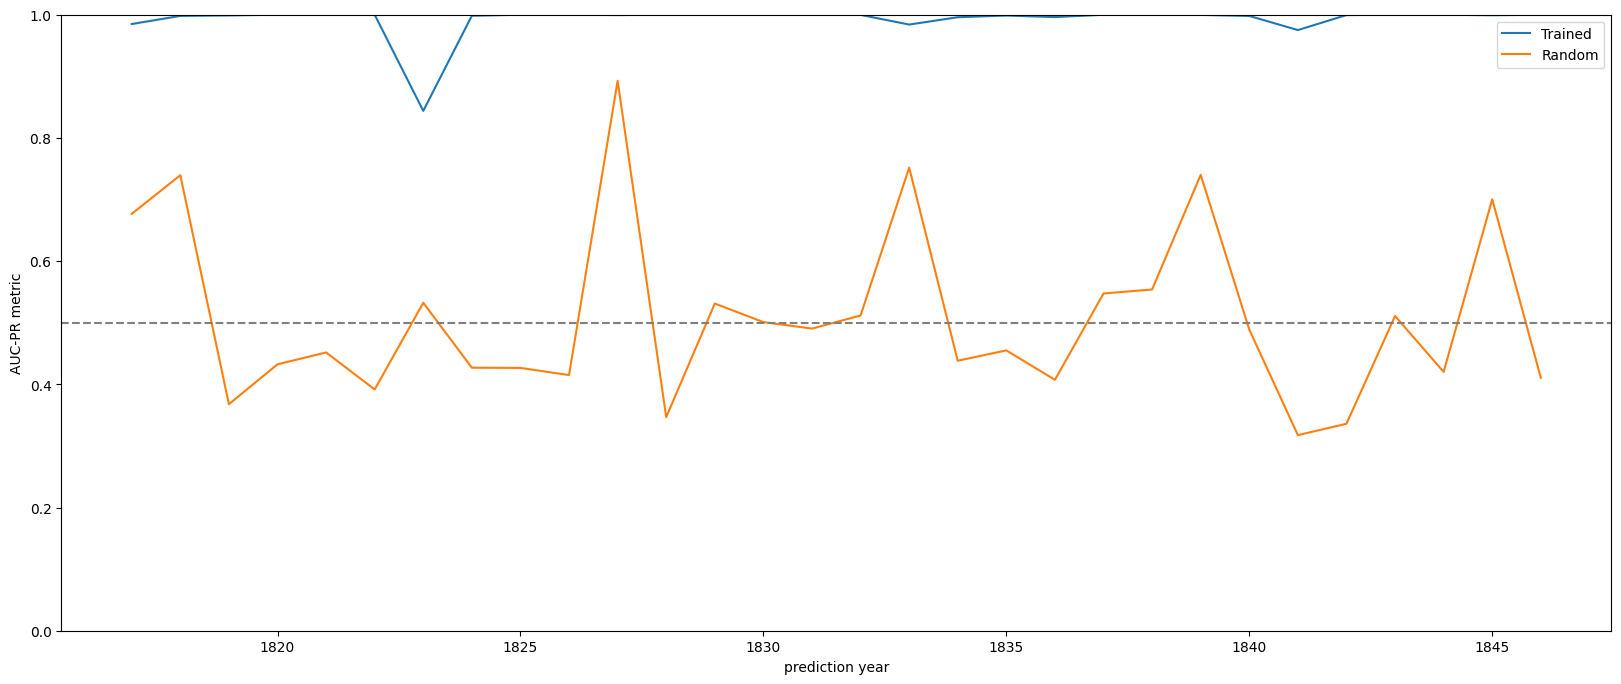

In [33]:
x = trained_results_df['Year'].values
y1 = trained_results_df['AUC-PR'].values
y2 = random_results_df['AUC-PR'].values[0:len(x)]
plt.figure(figsize=(20,8))
plt.plot(x,y1, label='Trained')
plt.plot(x,y2, label='Random')
plt.ylabel('AUC-PR metric')
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.xlabel('prediction year')
plt.ylim(0, 1)
plt.legend()
plt.show()

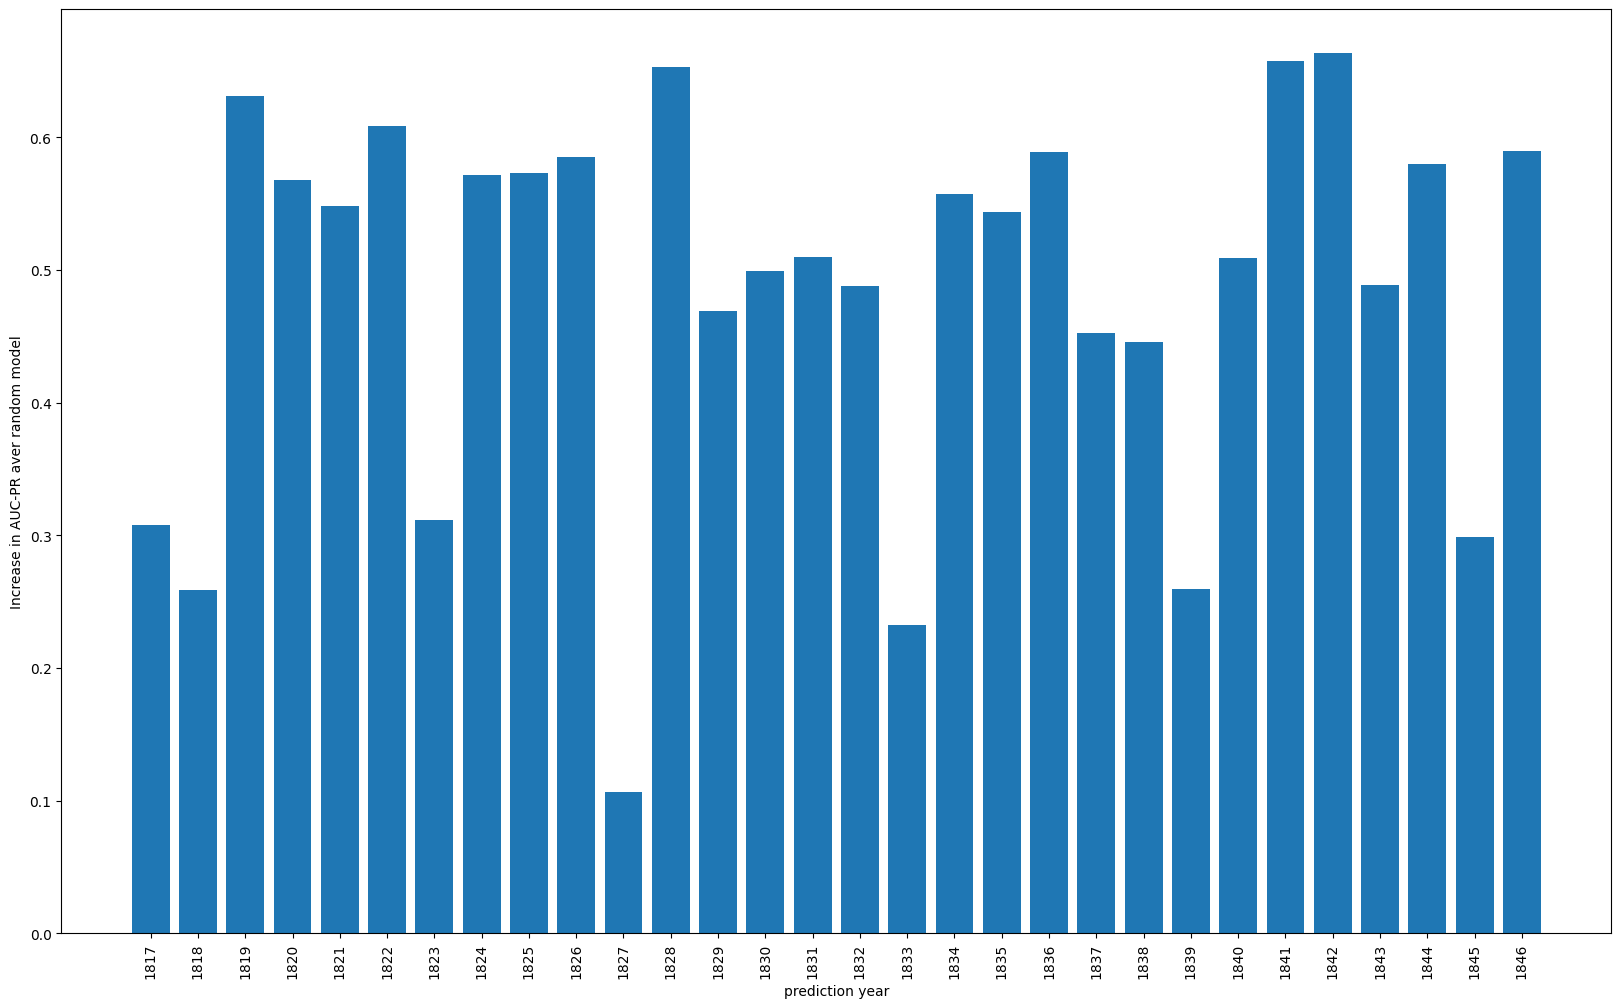

In [34]:
x = trained_results_df['Year'].values
y1 = trained_results_df['AUC-PR'].values
y2 = random_results_df['AUC-PR'].values[0:len(x)]
plt.figure(figsize=(20,12))
plt.bar([str(a) for a in x],y1-y2)
plt.ylabel('Increase in AUC-PR aver random model')
plt.xlabel('prediction year')
plt.xticks(rotation=90)
plt.show()

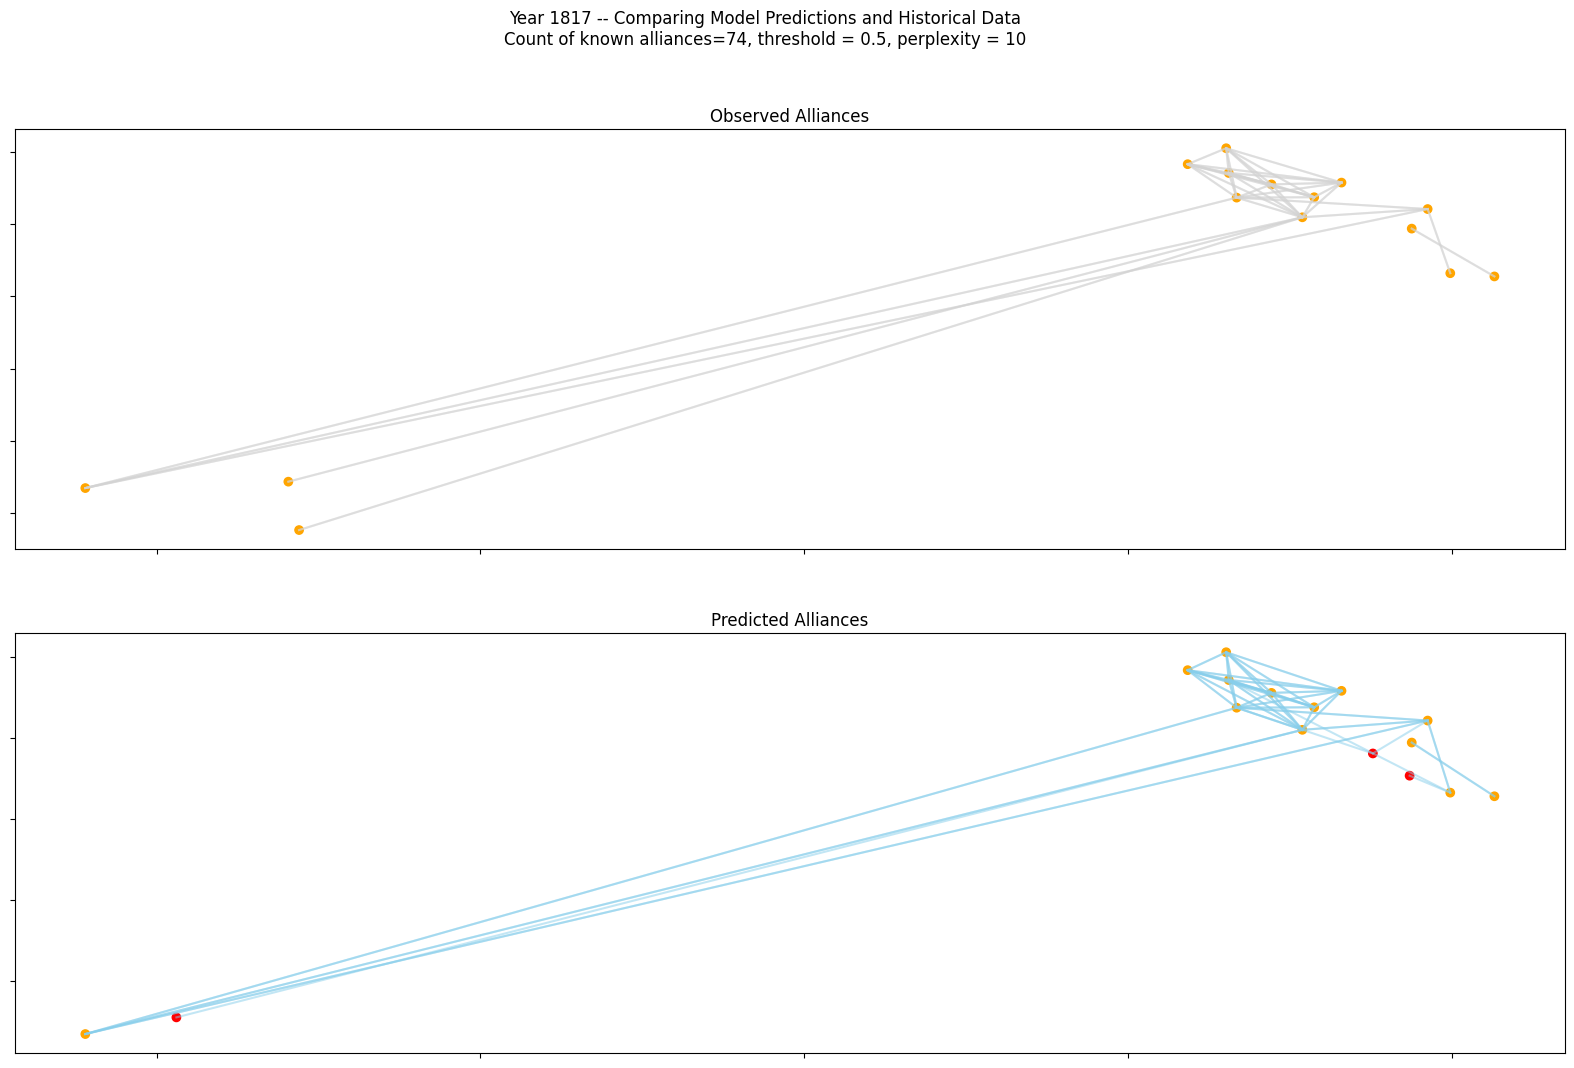

In [35]:
#use optimal threshold
compare_model_to_data(eval_year=1817, threshold=0.5, perplexity=10, \
                      model_folder='./models/', all_data=all_data, all_parms=all_parms)

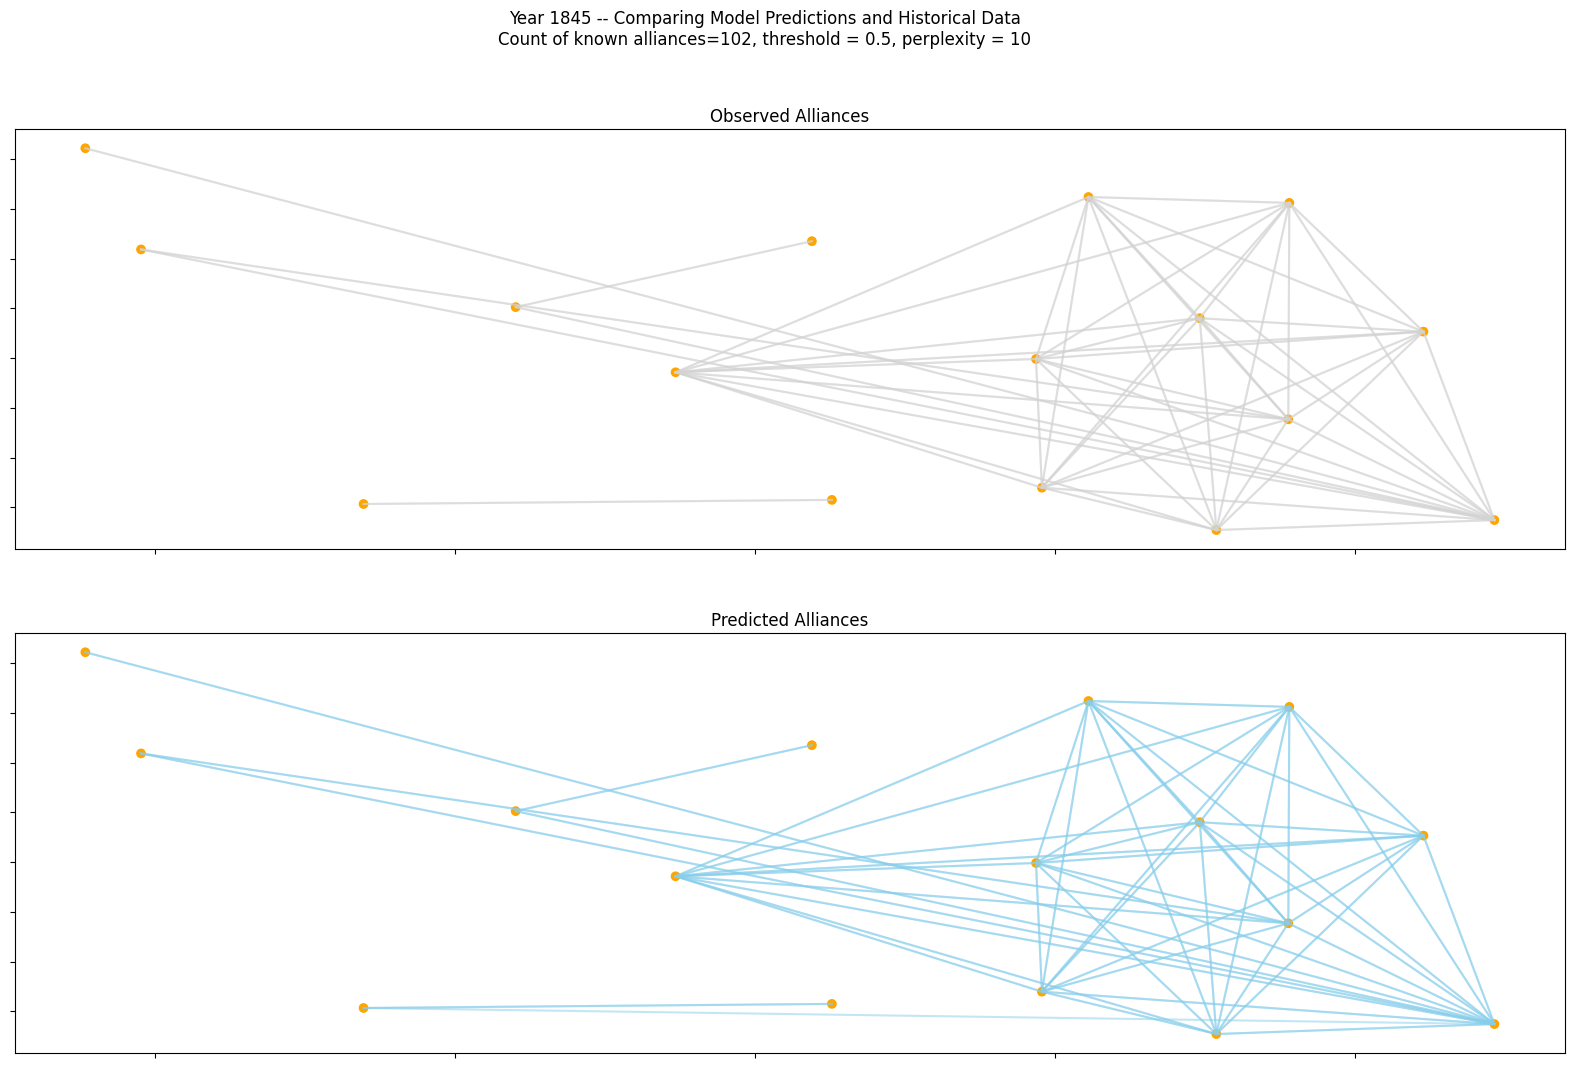

In [36]:
#use optimal threshold
compare_model_to_data(eval_year=1845, threshold=0.5, perplexity=10, \
                      model_folder='./models/', all_data=all_data, all_parms=all_parms)

In [184]:
all_parms

{'in_channels': 184,
 'hidden_channels': 128,
 'out_channels': 128,
 'num_edge_features': 7,
 'num_layers': 2,
 'dropout': 0.2,
 'learning_rate': 0.0001,
 'weight_decay': 0.0005,
 'negative_ratio': 1,
 'n_epochs': 1000,
 'print_interval': 1,
 'max_distance': 3}

In [181]:
%%time

test_parms = all_parms.copy()
test_parms['negative_ratio'] = 10
changes_df = None
thresholds = [0.001, 0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 0.999]
for threshold in thresholds:
    for eval_year in years[1:31]:
        model_name = 'base_' + str(eval_year) + '.pt'
        model_folder = './models/'
        model, hidden = load_saved_model(model_folder, eval_year, all_parms=all_parms, restore=True)
        if hidden is not None:   #model has been trained and saved in a checkpoint
            th, test_results, test_all_edges, test_edge_pred, test_pred, \
                test_labels, test_data, test_src, test_dest = \
                predict_test_year(model, eval_year, all_data, test_parms, hidden, eval_year-1)

        new_edges, deleted_edges = find_new_and_deleted_edges(temporal_edges_tensor[eval_year], temporal_edges_tensor[eval_year-1])
        new_edges_unique_indices = find_unique_undirected_edges_indices(new_edges)
        deduped_new_edges = new_edges[:,new_edges_unique_indices] if len(new_edges) > 0 else []
        deleted_edges_unique_indices = find_unique_undirected_edges_indices(deleted_edges)
        deduped_deleted_edges = deleted_edges[:,deleted_edges_unique_indices] if len(deleted_edges) > 0 else []

        if len(deduped_new_edges) > 0:
            new_edge_predictions = test_edge_pred[new_edges_unique_indices]
            predictions_above_threshold = np.where(new_edge_predictions > threshold)[0]
            newly_added_test_pairs = new_edges[:,new_edges_unique_indices]
            newly_added_correct_test_pairs = new_edges[:,new_edges_unique_indices][:,predictions_above_threshold]

            for i in range(newly_added_test_pairs.shape[1]):
                change_results = {}
                change_results['year'] = eval_year
                change_results['threshold'] = threshold
                pair = newly_added_test_pairs[:,i]
                states = sorted(country_codes_df[country_codes_df['CCode'].isin(np.array(countries)[pair])]['StateNme'].values.tolist())
                change_results['alliance'] = states
                change_results['recent_change'] = 'added'
                if new_edge_predictions[i] > threshold:
                    change_results['model_prediction'] = 'Correct'
                else:
                    change_results['model_prediction'] = 'Wrong'
                change_results['model_score'] = new_edge_predictions[i]
                changes_df = pd.DataFrame([change_results]) if changes_df is None else changes_df.append([change_results])

        if len(deduped_deleted_edges) > 0:
            deleted_edge_predictions = test_edge_pred[deleted_edges_unique_indices]
            predictions_below_threshold = np.where(deleted_edge_predictions <= threshold)[0]
            newly_deleted_test_pairs = deleted_edges[:,deleted_edges_unique_indices]
            newly_deleted_correct_test_pairs = deleted_edges[:,deleted_edges_unique_indices][:,predictions_below_threshold]

            for i in range(newly_deleted_test_pairs.shape[1]):
                change_results = {}
                change_results['year'] = eval_year
                change_results['threshold'] = threshold
                pair = newly_deleted_test_pairs[:,i]
                states = sorted(country_codes_df[country_codes_df['CCode'].isin(np.array(countries)[pair])]['StateNme'].values.tolist())
                change_results['alliance'] = states
                change_results['recent_change'] = 'deleted'
                if deleted_edge_predictions[i] <= threshold:
                    change_results['model_prediction'] = 'Correct'
                else:
                    change_results['model_prediction'] = 'Wrong'
                change_results['model_score'] = deleted_edge_predictions[i]
                changes_df = pd.DataFrame([change_results]) if changes_df is None else changes_df.append([change_results])

print(changes_df.shape)
changes_df.head(10)

(583, 6)
CPU times: user 22.2 s, sys: 587 ms, total: 22.8 s
Wall time: 22.3 s


,year,threshold,alliance,recent_change,model_prediction,model_score
0,1821,0.001,"[Austria-Hungary, Two Sicilies]",added,Correct,0.013274
0,1821,0.001,"[Netherlands, Spain]",added,Correct,0.014725
0,1823,0.001,"[Austria-Hungary, United Kingdom]",added,Correct,0.002041
0,1823,0.001,"[Austria-Hungary, Russia]",added,Correct,0.001877
0,1823,0.001,"[Germany, United Kingdom]",added,Correct,0.635102
0,1823,0.001,"[Russia, United Kingdom]",added,Correct,0.452879
0,1823,0.001,"[Germany, Russia]",added,Correct,0.326128
0,1831,0.001,"[Austria-Hungary, Italy]",deleted,Wrong,0.018422
0,1832,0.001,"[France, United Kingdom]",deleted,Wrong,0.006419
0,1832,0.001,"[Belgium, France]",deleted,Wrong,0.007439


In [182]:
added_accuracies = OrderedDict()
deleted_accuracies = OrderedDict()
for threshold in changes_df['threshold'].unique():
    n_add_correct = len(changes_df[ (changes_df['threshold'] == threshold) & (changes_df['recent_change'] == 'added') & (changes_df['model_prediction'] == 'Correct') ])
    n_add = len(changes_df[ (changes_df['threshold'] == threshold) & (changes_df['recent_change'] == 'added')])
    
    n_del_correct = len(changes_df[ (changes_df['threshold'] == threshold) & (changes_df['recent_change'] == 'deleted') & (changes_df['model_prediction'] == 'Correct') ])
    n_del = len(changes_df[ (changes_df['threshold'] == threshold) & (changes_df['recent_change'] == 'deleted')])
    
    if n_add > 0:
        added_accuracies[threshold] = round(n_add_correct / n_add * 100.0, 6)
    if n_del > 0:
        deleted_accuracies[threshold] = round(n_del_correct / n_del * 100.0, 6)

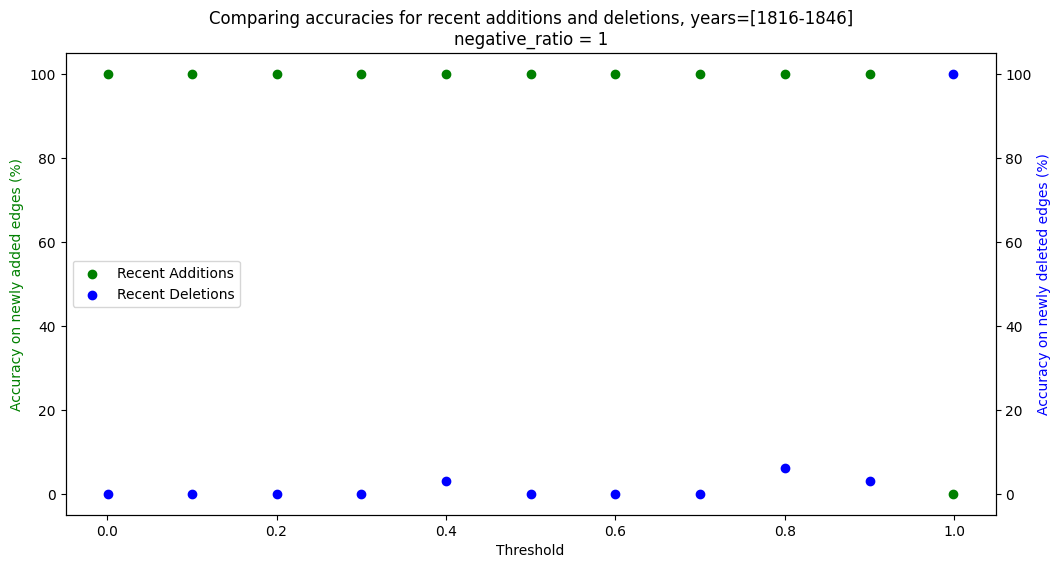

In [174]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
x1 = list(added_accuracies.keys())
y1 = list(added_accuracies.values())
x2 = list(deleted_accuracies.keys())
y2 = list(deleted_accuracies.values())
line1 = ax1.scatter(x1, y1, label='Recent Additions', color='g')
line2 = ax2.scatter(x2, y2, label='Recent Deletions', color='b')
lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy on newly added edges (%)', color='g')
ax2.set_ylabel('Accuracy on newly deleted edges (%)', color='b')

ax1.legend(lines, labels, loc='center left')
plt.title("Comparing accuracies for recent additions and deletions, years=[" + \
          str(years[0:31][0]) + '-' + str(years[0:31][-1]) + ']' + '\nnegative_ratio = ' + str(test_parms['negative_ratio']))

#for i, label in enumerate(y1):
#    ax1.annotate(label, (x1[i], y1[i]))
#for i, label in enumerate(y2):
#    ax2.annotate(label, (x2[i], y2[i]))
#ax1.set_ylim(80, 110)
#ax2.set_ylim(-10, 20)

plt.show()

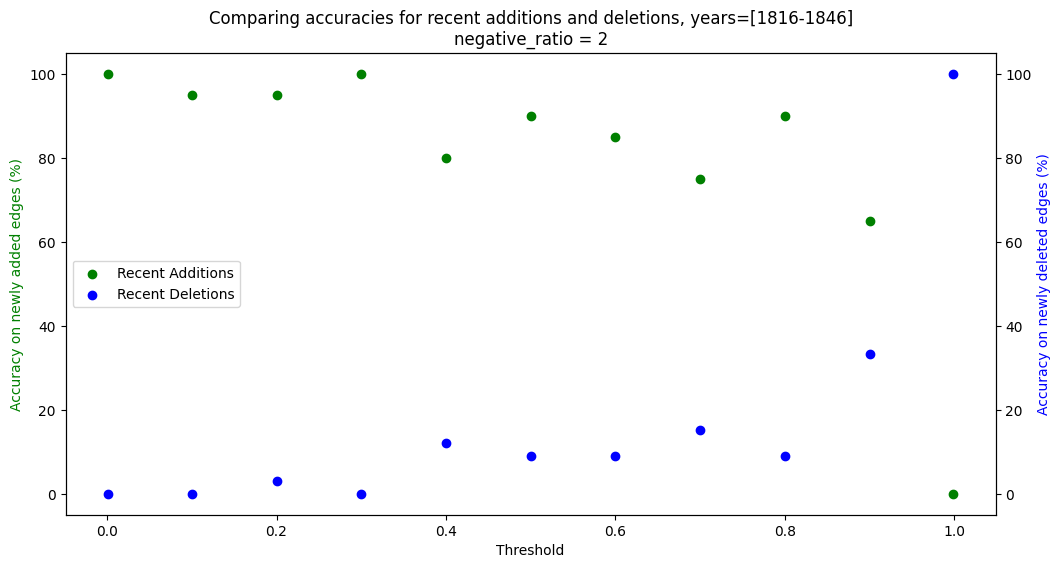

In [177]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
x1 = list(added_accuracies.keys())
y1 = list(added_accuracies.values())
x2 = list(deleted_accuracies.keys())
y2 = list(deleted_accuracies.values())
line1 = ax1.scatter(x1, y1, label='Recent Additions', color='g')
line2 = ax2.scatter(x2, y2, label='Recent Deletions', color='b')
lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy on newly added edges (%)', color='g')
ax2.set_ylabel('Accuracy on newly deleted edges (%)', color='b')

ax1.legend(lines, labels, loc='center left')
plt.title("Comparing accuracies for recent additions and deletions, years=[" + \
          str(years[0:31][0]) + '-' + str(years[0:31][-1]) + ']' + '\nnegative_ratio = ' + str(test_parms['negative_ratio']))

#for i, label in enumerate(y1):
#    ax1.annotate(label, (x1[i], y1[i]))
#for i, label in enumerate(y2):
#    ax2.annotate(label, (x2[i], y2[i]))
#ax1.set_ylim(80, 110)
#ax2.set_ylim(-10, 20)

plt.show()

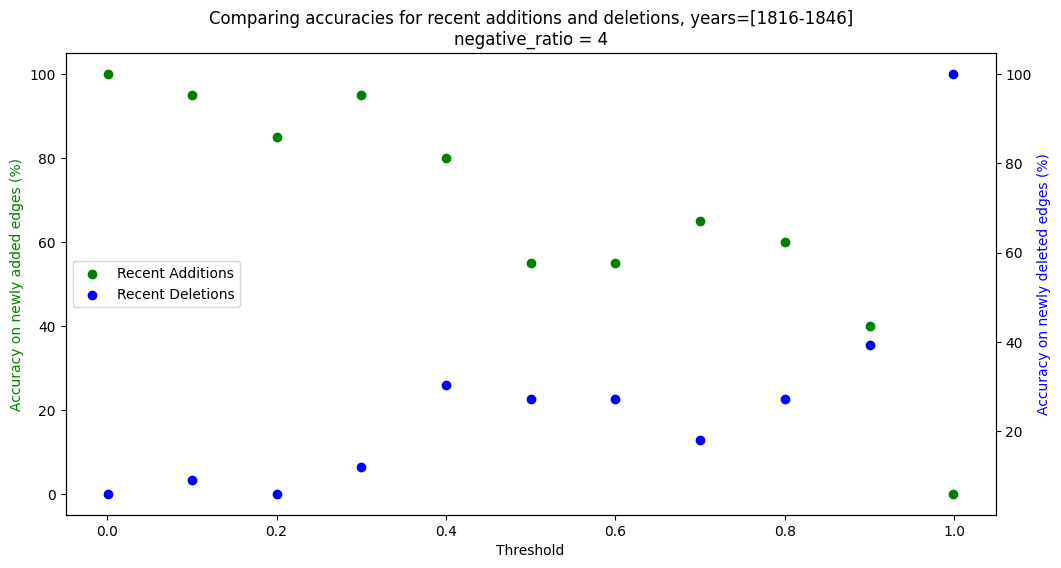

In [180]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
x1 = list(added_accuracies.keys())
y1 = list(added_accuracies.values())
x2 = list(deleted_accuracies.keys())
y2 = list(deleted_accuracies.values())
line1 = ax1.scatter(x1, y1, label='Recent Additions', color='g')
line2 = ax2.scatter(x2, y2, label='Recent Deletions', color='b')
lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy on newly added edges (%)', color='g')
ax2.set_ylabel('Accuracy on newly deleted edges (%)', color='b')

ax1.legend(lines, labels, loc='center left')
plt.title("Comparing accuracies for recent additions and deletions, years=[" + \
          str(years[0:31][0]) + '-' + str(years[0:31][-1]) + ']' + '\nnegative_ratio = ' + str(test_parms['negative_ratio']))

#for i, label in enumerate(y1):
#    ax1.annotate(label, (x1[i], y1[i]))
#for i, label in enumerate(y2):
#    ax2.annotate(label, (x2[i], y2[i]))
#ax1.set_ylim(80, 110)
#ax2.set_ylim(-10, 20)

plt.show()

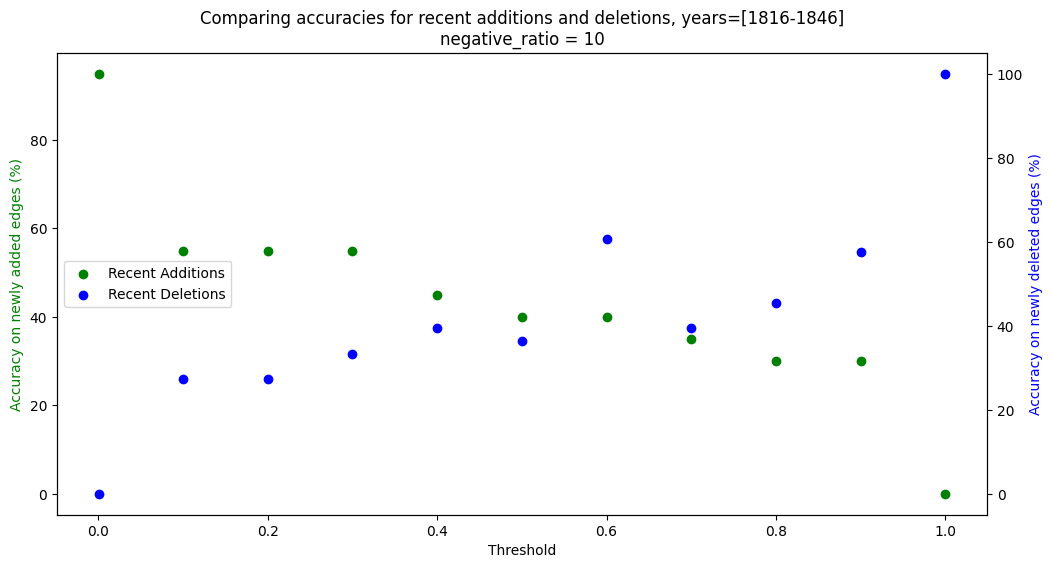

In [183]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
x1 = list(added_accuracies.keys())
y1 = list(added_accuracies.values())
x2 = list(deleted_accuracies.keys())
y2 = list(deleted_accuracies.values())
line1 = ax1.scatter(x1, y1, label='Recent Additions', color='g')
line2 = ax2.scatter(x2, y2, label='Recent Deletions', color='b')
lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy on newly added edges (%)', color='g')
ax2.set_ylabel('Accuracy on newly deleted edges (%)', color='b')

ax1.legend(lines, labels, loc='center left')
plt.title("Comparing accuracies for recent additions and deletions, years=[" + \
          str(years[0:31][0]) + '-' + str(years[0:31][-1]) + ']' + '\nnegative_ratio = ' + str(test_parms['negative_ratio']))

#for i, label in enumerate(y1):
#    ax1.annotate(label, (x1[i], y1[i]))
#for i, label in enumerate(y2):
#    ax2.annotate(label, (x2[i], y2[i]))
#ax1.set_ylim(80, 110)
#ax2.set_ylim(-10, 20)

plt.show()